# 0 Import packages

In [1]:
import pandas as pd
from poola import core as pool
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gpplot as gpp
import function as f
import statistics 
import scipy.stats as stats
import researchpy as rp
import re

pd.set_option('max_colwidth', -1)

/var/folders/h4/ryygmkjj3m32xw7cjfk2gbvr0000gq/T/ipykernel_93097/478852975.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


# 1 Import Files

In [2]:
path = ('../../manuscript data/Supplementary Data Files/')
supp_data_3 = pd.read_excel(path + '/Supplementary Data 3.xlsx', 'Library annotation')
supp_data_3 = supp_data_3[(supp_data_3['Design window'] == 'wide') & (supp_data_3['Set'] == 'B')]

wide_setb_anno = pd.read_excel(path + '/Supplementary Data 3.xlsx', 'SetB;Wide',skiprows=2, 
                                 names = ['Construct IDs',
                                          'pDNA_Wide_VP64_setB',
                                          'pDNA_Wide_p65_setB',
                                          'Wide_VP64_setB_untreated_repA',
                                          'Wide_VP64_setB_untreated_repB',
                                          'Wide_VP64_setB_Selumetinib_repA',
                                          'Wide_VP64_setB_Selumetinib_repB',
                                          'Wide_p65_setB_untreated_repA',
                                          'Wide_p65_setB_untreated_repB',
                                          'Wide_p65_setB_Selumetinib_repA',
                                          'Wide_p65_setB_Selumetinib_repB'])

In [3]:
wide_vp64_setb = pd.merge(wide_setb_anno[['Construct IDs',
                                          'pDNA_Wide_VP64_setB',
                                          'Wide_VP64_setB_untreated_repA',
                                          'Wide_VP64_setB_untreated_repB',
                                          'Wide_VP64_setB_Selumetinib_repA',
                                          'Wide_VP64_setB_Selumetinib_repB']],
         supp_data_3[['Guide 1', 'Gene Symbol']].
                           rename(columns={'Guide 1': 'Construct Barcode','Gene Symbol':'Construct IDs'}),
         on = 'Construct IDs')
         

In [4]:
wide_vp64_setb.head()

,Construct IDs,pDNA_Wide_VP64_setB,Wide_VP64_setB_untreated_repA,Wide_VP64_setB_untreated_repB,Wide_VP64_setB_Selumetinib_repA,Wide_VP64_setB_Selumetinib_repB,Construct Barcode
0,A1BG,499.0,392.0,405.0,286.0,280.0,AGCCCCGGCACTCTCCACTTGAC
1,A1CF,957.0,797.0,700.0,790.0,596.0,CAATTCCTGGGAGTTAAACTTTA
2,A2M,789.0,713.0,703.0,683.0,512.0,TGGCGGGCTAAATAGAATCCCTG
3,A2ML1,939.0,904.0,903.0,976.0,703.0,CCATTATGAATACTCAGCTCTGG
4,A3GALT2,185.0,199.0,213.0,173.0,135.0,AGGTGATTGGCCCCAAAAGGGTT


# 2 Find Olfactory Genes

In [5]:

olfactory_gene = [gene for gene in wide_vp64_setb['Construct IDs'].tolist() if gene.startswith('OR')]
# A nomenclature system has been devised for the olfactory receptor family[33] and is the basis for the official Human Genome Project (HUGO) symbols for the genes that encode these receptors. The names of individual olfactory receptor family members are in the format "ORnXm" where:

# OR is the root name (Olfactory Receptor superfamily)
# n = an integer representing a family (e.g., 1-56) whose members have greater than 40% sequence identity,
# X = a single letter (A, B, C, ...) denoting a subfamily (>60% sequence identity), and
# m = an integer representing an individual family member (isoform).
# checked X could be mutiple letters

ofg_l = []
no_ofg_l = []
for ofg in olfactory_gene:
    match = re.search('^OR\d{1,2}[A-Z]{1,2}[0-9]?[0-9]', ofg)
    if match:
        ofg_l.append(ofg)
    else:
        no_ofg_l.append(ofg)
        


olfactory_gene = ofg_l


# 3 Calculate LFC 

In [6]:
OG_read_counts = wide_vp64_setb

In [7]:
OG_read_counts.rename(columns = {'pDNA_Wide_VP64_setB':"pDNA", 
                                 'Wide_VP64_setB_untreated_repA':"untreated_repA",
                                 'Wide_VP64_setB_untreated_repB':"untreated_repB", 
                                 'Wide_VP64_setB_Selumetinib_repA':"Selumetinib_repA",
                                 'Wide_VP64_setB_Selumetinib_repB':"Selumetinib_repB"
                                }, inplace= True)


In [8]:
OG_read_counts.head()

,Construct IDs,pDNA,untreated_repA,untreated_repB,Selumetinib_repA,Selumetinib_repB,Construct Barcode
0,A1BG,499.0,392.0,405.0,286.0,280.0,AGCCCCGGCACTCTCCACTTGAC
1,A1CF,957.0,797.0,700.0,790.0,596.0,CAATTCCTGGGAGTTAAACTTTA
2,A2M,789.0,713.0,703.0,683.0,512.0,TGGCGGGCTAAATAGAATCCCTG
3,A2ML1,939.0,904.0,903.0,976.0,703.0,CCATTATGAATACTCAGCTCTGG
4,A3GALT2,185.0,199.0,213.0,173.0,135.0,AGGTGATTGGCCCCAAAAGGGTT


In [9]:
#calculating lognorms
OG_lognorms = pool.lognorm_columns(reads_df=OG_read_counts, columns=['pDNA', 'untreated_repA',
                                                                     'untreated_repB','Selumetinib_repA',
                                                                     'Selumetinib_repB'])


In [10]:
OG_lognorms.head()

,Construct IDs,pDNA,untreated_repA,untreated_repB,Selumetinib_repA,Selumetinib_repB,Construct Barcode
0,A1BG,5.014237,5.083036,5.037127,4.544767,4.678808,AGCCCCGGCACTCTCCACTTGAC
1,A1CF,5.932192,6.084969,5.807923,5.970622,5.738516,CAATTCCTGGGAGTTAAACTTTA
2,A2M,5.658720,5.926793,5.813983,5.764255,5.523774,TGGCGGGCTAAATAGAATCCCTG
3,A2ML1,5.905251,6.264195,6.169493,6.271259,5.972610,CCATTATGAATACTCAGCTCTGG
4,A3GALT2,3.656570,4.145650,4.149132,3.859343,3.685606,AGGTGATTGGCCCCAAAAGGGTT


In [11]:
# remove pDNA with low abundance
OG_filtered_lognorms = pool.filter_pdna(lognorm_df=OG_lognorms, pdna_cols=['pDNA'], z_low=-3)
print('Filtered ' + str(OG_lognorms.shape[0] - OG_filtered_lognorms.shape[0]) + ' rows due to low pDNA abundance')

Filtered 107 rows due to low pDNA abundance


### Dropout - pdna (viability effect)

In [12]:
#calculating lfc from pDNA
OG_lfc_df_from_pDNA = pool.calculate_lfcs(lognorm_df=OG_filtered_lognorms, ref_col='pDNA', 
                             target_cols=['untreated_repA','untreated_repB','Selumetinib_repA',
                                                                     'Selumetinib_repB'])

In [13]:
#calculating avg lfc for untreated samples
OG_lfc_df_from_pDNA['avg_lfc_untreated'] = OG_lfc_df_from_pDNA[['untreated_repA', 'untreated_repB']].mean(axis=1)

Text(0.5, 1.0, 'Wide VP64 setB: Viability effect')

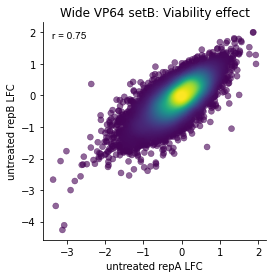

In [14]:
#plotting dropout replicate correlations (lfc from pDNA)
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=OG_lfc_df_from_pDNA, x='untreated_repA', y='untreated_repB')
gpplot.add_correlation(data=OG_lfc_df_from_pDNA, x='untreated_repA', y='untreated_repB')
sns.despine()
plt.xlabel('untreated repA LFC')
plt.ylabel('untreated repB LFC')
plt.title('Wide VP64 setB: Viability effect')


### Selumetinib - Dropout 


In [15]:
OG_filtered_lognorms_repA = OG_filtered_lognorms[['Construct Barcode', 'Construct IDs','Selumetinib_repA','untreated_repA']]
OG_filtered_lognorms_repB = OG_filtered_lognorms[['Construct Barcode', 'Construct IDs','Selumetinib_repB','untreated_repB']]

In [16]:
#calculating lfc from dropout
OG_lfc_df_from_dropout_repA = pool.calculate_lfcs(lognorm_df=OG_filtered_lognorms_repA, ref_col='untreated_repA', 
                             target_cols=['Selumetinib_repA'])

In [17]:
OG_lfc_df_from_dropout_repB = pool.calculate_lfcs(lognorm_df=OG_filtered_lognorms_repB, ref_col='untreated_repB', 
                             target_cols=['Selumetinib_repB'])

In [18]:
OG_lfc_df_from_dropout = pd.merge(OG_lfc_df_from_dropout_repA, OG_lfc_df_from_dropout_repB)
#calculating avg lfc for selumetinib samples
OG_lfc_df_from_dropout['avg_lfc_selumetinib'] = OG_lfc_df_from_dropout[['Selumetinib_repA', 'Selumetinib_repB']].mean(axis=1)

Text(0.5, 1.0, 'Wide VP64 setB: Drug effect')

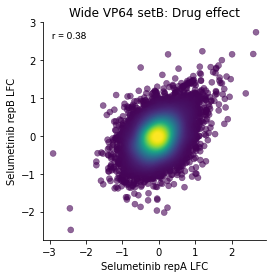

In [19]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=OG_lfc_df_from_dropout, x='Selumetinib_repA', y='Selumetinib_repB')
gpplot.add_correlation(data=OG_lfc_df_from_dropout, x='Selumetinib_repA', y='Selumetinib_repB')
sns.despine()
plt.xlabel('Selumetinib repA LFC')
plt.ylabel('Selumetinib repB LFC')
plt.title('Wide VP64 setB: Drug effect')


# 4 Calculate Z-scores

#### Drug Screens

In [20]:
# find the olfactory gene mean and sd
olfactory_gene_df = OG_lfc_df_from_dropout[OG_lfc_df_from_dropout['Construct IDs'].isin(olfactory_gene)]
olfactory_mean = statistics.mean(olfactory_gene_df.avg_lfc_selumetinib)
olfactory_sd = statistics.stdev(olfactory_gene_df.avg_lfc_selumetinib)

In [21]:
# Z-score in respect to the olfactory genes
OG_lfc_df_from_dropout['z_scored_olfactory_gene'] = (OG_lfc_df_from_dropout.avg_lfc_selumetinib - olfactory_mean)/olfactory_sd
OG_lfc_df_from_dropout.head()

,Construct Barcode,Construct IDs,Selumetinib_repA,Selumetinib_repB,avg_lfc_selumetinib,z_scored_olfactory_gene
0,AGCCCCGGCACTCTCCACTTGAC,A1BG,-0.538269,-0.358319,-0.448294,-1.524444
1,CAATTCCTGGGAGTTAAACTTTA,A1CF,-0.114347,-0.069407,-0.091877,-0.229405
2,TGGCGGGCTAAATAGAATCCCTG,A2M,-0.162539,-0.290209,-0.226374,-0.718099
3,CCATTATGAATACTCAGCTCTGG,A2ML1,0.007065,-0.196884,-0.094910,-0.240422
4,AGGTGATTGGCCCCAAAAGGGTT,A3GALT2,-0.286307,-0.463526,-0.374917,-1.257828


In [22]:
OG_lfc_df_from_dropout.to_csv('primary screen processed data/wide_VP64_setb_lfc_drug_effect.csv',
                             index = False)


#### Viability effect

In [23]:
# find the olfactory gene mean and sd
olfactory_gene_df_via = OG_lfc_df_from_pDNA[OG_lfc_df_from_pDNA['Construct IDs'].isin(olfactory_gene)]
olfactory_mean_via = statistics.mean(olfactory_gene_df_via.avg_lfc_untreated)
olfactory_sd_via = statistics.stdev(olfactory_gene_df_via.avg_lfc_untreated)

In [24]:
# Z-score in respect to the olfactory genes
OG_lfc_df_from_pDNA['z_scored_olfactory_gene'] = (OG_lfc_df_from_pDNA.avg_lfc_untreated - olfactory_mean_via)/olfactory_sd_via
OG_lfc_df_from_pDNA.head()

,Construct IDs,untreated_repA,untreated_repB,Selumetinib_repA,Selumetinib_repB,Construct Barcode,avg_lfc_untreated,z_scored_olfactory_gene
0,A1BG,0.068798,0.022890,-0.469470,-0.335429,AGCCCCGGCACTCTCCACTTGAC,0.045844,-0.038300
1,A1CF,0.152777,-0.124269,0.038430,-0.193676,CAATTCCTGGGAGTTAAACTTTA,0.014254,-0.121528
2,A2M,0.268073,0.155263,0.105534,-0.134946,TGGCGGGCTAAATAGAATCCCTG,0.211668,0.398588
3,A2ML1,0.358944,0.264243,0.366008,0.067359,CCATTATGAATACTCAGCTCTGG,0.311593,0.661856
4,A3GALT2,0.489080,0.492562,0.202773,0.029036,AGGTGATTGGCCCCAAAAGGGTT,0.490821,1.134060


In [25]:
OG_lfc_df_from_pDNA.to_csv('../../manuscript data/primary screen processed data/wide_VP64_setb_lfc_viability_effect.csv',
                             index = False)
